In [14]:
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

# Tải dữ liệu cổ phiếu
symbol = "AAPL"  # Thay bằng mã cổ phiếu bạn muốn dự đoán
data = yf.download(symbol, start="2020-01-01", end="2025-03-06")

# Tiền xử lý dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

# Chuẩn bị dữ liệu huấn luyện
sequence_length = 60
X_train, y_train = [], []
for i in range(sequence_length, len(data_scaled)):
    X_train.append(data_scaled[i-sequence_length:i, 0])
    y_train.append(data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], 1)),
    LSTM(units=50, return_sequences=True),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Dự đoán 5 ngày tiếp theo
X_input = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)
future_days = 5
dates = [datetime(2025, 3, 6) + timedelta(days=i) for i in range(1, future_days + 1)]

predictions = []
for _ in range(future_days):
    pred = model.predict(X_input)
    predictions.append(pred[0, 0])
    
    # Cập nhật X_input để tiếp tục dự đoán
    X_input = np.roll(X_input, -1, axis=1)
    X_input[0, -1, 0] = pred.item()  # Chuyển pred thành một số thực

# Chuyển kết quả thành DataFrame
df_predictions = pd.DataFrame({'Date': dates, 'Predicted Value': scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()})
print(df_predictions)

[*********************100%***********************]  1 of 1 completed

Epoch 1/10


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0833
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0023
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0010
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 9.8513e-04
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 9.4579e-04 
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 8.8149e-04 
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 9.5956e-04
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 9.1975e-04
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 8.8263e-04
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 8.7468e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
        Date  Predicted Value
0 2025-03-07       239.697495
1 2025-03-08       239.281036
2 2025-03-09       238.925095
3 2025-03

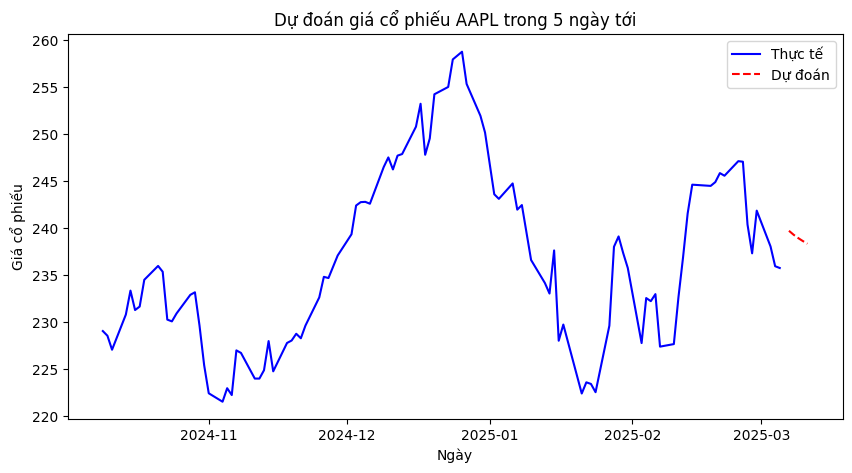

In [20]:
# Vẽ biểu đồ dự đoán
plt.figure(figsize=(10,5))
plt.plot(data.index[-100:], scaler.inverse_transform(data_scaled[-100:]), label='Thực tế', color='blue')
plt.plot(df_predictions['Date'], df_predictions['Predicted Value'], label='Dự đoán', color='red', linestyle='dashed')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title(f'Dự đoán giá cổ phiếu {symbol} trong 5 ngày tới')
plt.legend()
plt.show()